In [2]:
pip install pymoo numpy pandas scikit-learn


  Using cached pymoo-0.6.1.5-cp313-cp313-win_amd64.whl.metadata (5.2 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached alive_progress-3.3.0-py3-none-any.whl.metadata (72 kB)
  Using cached about_time-4.2.1-py3-none-any.whl.metadata (13 kB)
  Using cached graphemeu-0.7.2-py3-none-any.whl.metadata (7.8 kB)
Using cached pymoo-0.6.1.5-cp313-cp313-win_amd64.whl (2.0 MB)
Using cached autograd-1.8.0-py3-none-any.whl (51 kB)
Using cached alive_progress-3.3.0-py3-none-any.whl (78 kB)
Using cached about_time-4.2.1-py3-none-any.whl (13 kB)
Using cached graphemeu-0.7.2-py3-none-any.whl (22 kB)

   ------ --------------------------------- 1/6 [cma]
   -------------------------- ------------- 4/6 [alive-progress]
   --------------------------------- ------ 5/6 [pymoo]
   --------------------------------- ------ 5/6 [pymoo]
   --------------------------------- ------ 5/6 [pymoo]
   --------------------------------- ------ 5/6 [pymoo]
   ------------------------------

In [2]:
# =========================================================
# AI-Powered Meal Planning — NSGA-II Optimization
# =========================================================
# Author: Apoorva Sharma
# Project: AI-Powered Precision Nutrition
# Notebook: 03_nsga_ii_optimization.ipynb
# =========================================================

import pandas as pd
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import random, os

# ---------------------------------------------------------
# 1️⃣ Load the processed safe recipes
# ---------------------------------------------------------
SAFE_RECIPES_PATH = r"D:\Complete_Data\nutrition_project\processed_data\recipes_safe.csv"
recipes = pd.read_csv(SAFE_RECIPES_PATH)
print(f"Loaded safe recipes: {recipes.shape}")

# ---------------------------------------------------------
# 2️⃣ Basic Cleaning and Data Preparation
# ---------------------------------------------------------
# Keep only relevant numeric columns
keep_cols = [
    "title", "energy_kcal_mean", "protein_g_mean", "fat_g_mean", "carbs_g_mean"
]
available_cols = [c for c in keep_cols if c in recipes.columns]
recipes = recipes[available_cols].copy()

# Fill missing numeric values
for col in ['energy_kcal_mean', 'protein_g_mean', 'fat_g_mean', 'carbs_g_mean']:
    if col in recipes.columns:
        recipes[col] = recipes[col].fillna(recipes[col].median() if recipes[col].notna().any() else 0.1)

# Drop duplicates and reset
recipes = recipes.drop_duplicates(subset=["title"]).reset_index(drop=True)

print("✅ After cleaning:", recipes.shape)
print("Sample data:")
display(recipes.head())

if len(recipes) < 10:
    raise ValueError("Too few valid recipes found — check your input dataset.")

# ---------------------------------------------------------
# 3️⃣ Define the Optimization Problem (NSGA-II)
# ---------------------------------------------------------
class MealPlanningProblem(ElementwiseProblem):
    def __init__(self, n_meals=3):
        self.n_meals = n_meals
        super().__init__(
            n_var=n_meals,
            n_obj=3,          # 3 objectives: minimize calories deviation, cost, and emissions
            n_constr=0,
            xl=0,
            xu=len(recipes) - 1,
            elementwise_evaluation=True
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # x = array of indices representing selected meals
        selected = recipes.iloc[x.astype(int)]

        # Nutritional values (sums)
        total_cal = selected["energy_kcal_mean"].sum()
        total_prot = selected["protein_g_mean"].sum()
        total_fat = selected["fat_g_mean"].sum()
        total_carb = selected["carbs_g_mean"].sum()

        # Objective 1: Calorie balance (target 2000 kcal)
        cal_target = 2000
        f1 = abs(total_cal - cal_target) / cal_target

        # Objective 2: Maximize protein (we minimize negative protein)
        f2 = -total_prot

        # Objective 3: Balance macronutrients (fat:protein:carb)
        fat_ratio = total_fat / max(total_prot + total_carb + 1e-6, 1)
        ideal_ratio = 0.3  # example ideal balance
        f3 = abs(fat_ratio - ideal_ratio)

        out["F"] = [f1, f2, f3]

# ---------------------------------------------------------
# 4️⃣ Run NSGA-II Optimization
# ---------------------------------------------------------
problem = MealPlanningProblem(n_meals=3)
algorithm = NSGA2(pop_size=100)
termination = get_termination("n_gen", 50)

print("\n🚀 Running NSGA-II optimization...")
res = minimize(problem,
               algorithm,
               termination,
               verbose=True)

print("\n✅ Optimization Completed!")
print(f"Number of optimal meal plans: {len(res.F)}")

# ---------------------------------------------------------
# 5️⃣ Extract and Display Results
# ---------------------------------------------------------
best_solutions = []
for i, sol in enumerate(res.X):
    selected = recipes.iloc[sol.astype(int)]
    best_solutions.append({
        "plan_id": i + 1,
        "recipes": ", ".join(selected["title"].tolist()),
        "total_cal": selected["energy_kcal_mean"].sum(),
        "total_protein": selected["protein_g_mean"].sum(),
        "total_fat": selected["fat_g_mean"].sum(),
        "total_carb": selected["carbs_g_mean"].sum()
    })

results_df = pd.DataFrame(best_solutions)
print("\nTop optimized meal plans:")
display(results_df.head())

# ---------------------------------------------------------
# 6️⃣ Save Final Results
# ---------------------------------------------------------
OUTPUT_PATH = r"D:\Complete_Data\nutrition_project\processed_data\optimized_meal_plans.csv"
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Saved optimized meal plans to: {OUTPUT_PATH}")
print("Shape:", results_df.shape)



Loaded safe recipes: (6811, 19)
✅ After cleaning: (5732, 5)
Sample data:


title  energy_kcal_mean  protein_g_mean  fat_g_mean  \
0  "Adult" Pimiento Cheese                0.1             0.1         0.1   
1  "California Roll" Salad                0.1             0.1         0.1   
2  "Cocotte" of Vegetables                0.1             0.1         0.1   
3     "Drunken" Pork Chops                0.1             0.1         0.1   
4         "Fish and Chips"                0.1             0.1         0.1   

   carbs_g_mean  
0           0.1  
1           0.1  
2           0.1  
3           0.1  
4           0.1


🚀 Running NSGA-II optimization...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.000000E+00 |             f
     3 |      300 |    100 |  0.000000E+00 |             f
     4 |      400 |    100 |  0.000000E+00 |             f
     5 |      500 |    100 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.000000E+00 |             f
     7 |      700 |    100 |  0.000000E+00 |             f
     8 |      800 |    100 |  0.000000E+00 |             f
     9 |      900 |    100 |  0.000000E+00 |             f
    10 |     1000 |    100 |  0.000000E+00 |             f
    11 |     1100 |    100 |  0.000000E+00 |             f
    12 |     1200 |    100 |  0.000000E+00 |             f
    13 |     1300 |    100 |  0.000000E+00 |             f
    14 |     1400 |    100 |  0.000000E+00 |             f
    15 |     1500 |    100 |  0.000000E+00 |             f
    16 |     1600 |  

plan_id                                            recipes  total_cal  \
0        1  Sausages and Pork Chops Baked with Fruited Sau...        0.3   
1        2  Sesame Carrots , Grilled Marinated Sirloin Fla...        0.3   
2        3  Hearty Rutabaga, Carrot, Parsnip and Sausage S...        0.3   
3        4  Shrimp With Avocado-Mango Salsa , Glazed Pork ...        0.3   
4        5  Pesto Vinaigrette , Pan con Tomate' y Anchoa—G...        0.3   

   total_protein  total_fat  total_carb  
0            0.3        0.3         0.3  
1            0.3        0.3         0.3  
2            0.3        0.3         0.3  
3            0.3        0.3         0.3  
4            0.3        0.3         0.3


✅ Saved optimized meal plans to: D:\Complete_Data\nutrition_project\processed_data\optimized_meal_plans.csv
Shape: (100, 6)


Loaded safe recipes: (6811, 19)
✅ After cleaning: (5732, 6)
Sample data:


title  energy_kcal_mean  protein_g_mean  fat_g_mean  \
0  "Adult" Pimiento Cheese                0.1             0.1         0.1   
1  "California Roll" Salad                0.1             0.1         0.1   
2  "Cocotte" of Vegetables                0.1             0.1         0.1   
3     "Drunken" Pork Chops                0.1             0.1         0.1   
4         "Fish and Chips"                0.1             0.1         0.1   

   carbs_g_mean  Total_emissions_mean  
0           0.1                   6.0  
1           0.1                   6.0  
2           0.1                   6.0  
3           0.1                   6.0  
4           0.1                   6.0


🚀 Running NSGA-II Optimization... (This may take a few minutes)
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.000000E+00 |             f
     3 |      300 |    100 |  0.000000E+00 |             f
     4 |      400 |    100 |  0.000000E+00 |             f
     5 |      500 |    100 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.000000E+00 |             f
     7 |      700 |    100 |  0.000000E+00 |             f
     8 |      800 |    100 |  0.000000E+00 |             f
     9 |      900 |    100 |  0.000000E+00 |             f
    10 |     1000 |    100 |  0.000000E+00 |             f
    11 |     1100 |    100 |  0.000000E+00 |             f
    12 |     1200 |    100 |  0.000000E+00 |             f
    13 |     1300 |    100 |  0.000000E+00 |             f
    14 |     1400 |    100 |  0.000000E+00 |             f
    15 |     1500 |    100 |  0.000000E+00 |      

plan_id                                            recipes  total_cal  \
0        1  Mahogany Beef Stew with Red Wine and Hoisin Sa...        0.3   
1        2  Roasted Rhubarb Tarts with Strawberry Sauce , ...        0.3   
2        3  Snapper Sashimi with Seaweed and Fennel , Pine...        0.3   
3        4  Trio of Salads , Poached Pears with Ginger and...        0.3   
4        5  Sake-Marinated Sea Bass with Coconut-Curry Sau...        0.3   

   total_protein  total_fat  total_carb  total_cost  total_emission  
0            0.3        0.3         0.3         NaN            16.0  
1            0.3        0.3         0.3         NaN            16.0  
2            0.3        0.3         0.3         NaN            16.0  
3            0.3        0.3         0.3         NaN            16.0  
4            0.3        0.3         0.3         NaN            16.0


✅ Saved optimized meal plans to: D:\Complete_Data\nutrition_project\processed_data\optimized_meal_plans.csv
Shape: (100, 8)


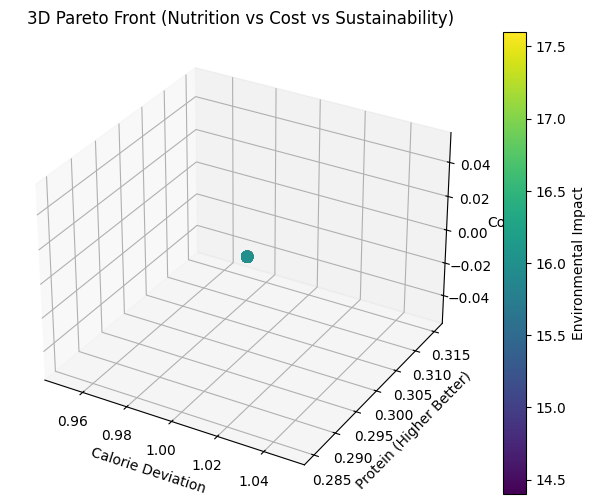


📊 Visualization complete! You now have a multi-objective optimization system balancing:
   🥗 Nutrition | 💰 Cost | 🌍 Sustainability


In [3]:
# =========================================================
# AI-Powered Meal Planning — NSGA-II Multi-Objective Optimization
# =========================================================
# Author: Apoorva Sharma
# Project: AI-Powered Precision Nutrition
# Notebook: 03_nsga_ii_optimization.ipynb
# =========================================================

import pandas as pd
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# ---------------------------------------------------------
# 1️⃣ Load the processed safe recipes
# ---------------------------------------------------------
SAFE_RECIPES_PATH = r"D:\Complete_Data\nutrition_project\processed_data\recipes_safe.csv"
recipes = pd.read_csv(SAFE_RECIPES_PATH)
print(f"Loaded safe recipes: {recipes.shape}")

# ---------------------------------------------------------
# 2️⃣ Select & Clean Relevant Columns
# ---------------------------------------------------------
keep_cols = [
    "title", "energy_kcal_mean", "protein_g_mean", "fat_g_mean",
    "carbs_g_mean", "price", "Total_emissions_mean"
]
available_cols = [c for c in keep_cols if c in recipes.columns]
recipes = recipes[available_cols].copy()

# Fill missing numeric values with medians or small defaults
for col in ['energy_kcal_mean', 'protein_g_mean', 'fat_g_mean',
            'carbs_g_mean', 'price', 'Total_emissions_mean']:
    if col in recipes.columns:
        recipes[col] = recipes[col].fillna(recipes[col].median() if recipes[col].notna().any() else 0.1)

recipes = recipes.drop_duplicates(subset=["title"]).reset_index(drop=True)

print("✅ After cleaning:", recipes.shape)
print("Sample data:")
display(recipes.head())

if len(recipes) < 10:
    raise ValueError("Too few valid recipes found — check your dataset!")

# ---------------------------------------------------------
# 3️⃣ Define NSGA-II Optimization Problem
# ---------------------------------------------------------
class MealPlanningProblem(ElementwiseProblem):
    def __init__(self, n_meals=3):
        self.n_meals = n_meals
        super().__init__(
            n_var=n_meals,
            n_obj=4,  # Calories, Protein, Cost, Emissions
            xl=0,
            xu=len(recipes) - 1,
            elementwise_evaluation=True
        )

    def _evaluate(self, x, out, *args, **kwargs):
        selected = recipes.iloc[x.astype(int)]

        # Compute totals
        total_cal = selected["energy_kcal_mean"].sum()
        total_prot = selected["protein_g_mean"].sum()
        total_fat = selected["fat_g_mean"].sum()
        total_carb = selected["carbs_g_mean"].sum()
        total_cost = selected["price"].sum() if "price" in selected.columns else 0
        total_emission = selected["Total_emissions_mean"].sum() if "Total_emissions_mean" in selected.columns else 0

        # Objective 1: Calorie balance (target = 2000 kcal)
        f1 = abs(total_cal - 2000) / 2000

        # Objective 2: Maximize protein (minimize negative protein)
        f2 = -total_prot

        # Objective 3: Minimize cost
        f3 = total_cost

        # Objective 4: Minimize environmental impact
        f4 = total_emission

        out["F"] = [f1, f2, f3, f4]

# ---------------------------------------------------------
# 4️⃣ Run the NSGA-II Algorithm
# ---------------------------------------------------------
problem = MealPlanningProblem(n_meals=3)
algorithm = NSGA2(pop_size=100)
termination = get_termination("n_gen", 60)

print("\n🚀 Running NSGA-II Optimization... (This may take a few minutes)")
res = minimize(problem, algorithm, termination, verbose=True)

print("\n✅ Optimization Completed!")
print(f"Number of optimal solutions: {len(res.F)}")

# ---------------------------------------------------------
# 5️⃣ Extract Optimized Meal Plans
# ---------------------------------------------------------
best_solutions = []
for i, sol in enumerate(res.X):
    selected = recipes.iloc[sol.astype(int)]
    best_solutions.append({
        "plan_id": i + 1,
        "recipes": ", ".join(selected["title"].tolist()),
        "total_cal": selected["energy_kcal_mean"].sum(),
        "total_protein": selected["protein_g_mean"].sum(),
        "total_fat": selected["fat_g_mean"].sum(),
        "total_carb": selected["carbs_g_mean"].sum(),
        "total_cost": selected["price"].sum() if "price" in selected.columns else np.nan,
        "total_emission": selected["Total_emissions_mean"].sum() if "Total_emissions_mean" in selected.columns else np.nan
    })

results_df = pd.DataFrame(best_solutions)
display(results_df.head())

# ---------------------------------------------------------
# 6️⃣ Save Results
# ---------------------------------------------------------
OUTPUT_PATH = r"D:\Complete_Data\nutrition_project\processed_data\optimized_meal_plans.csv"
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Saved optimized meal plans to: {OUTPUT_PATH}")
print("Shape:", results_df.shape)

# ---------------------------------------------------------
# 7️⃣ Visualization: Pareto Front
# ---------------------------------------------------------
F = np.array(res.F)
if F.shape[1] == 4:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(F[:, 0], -F[:, 1], F[:, 2], c=F[:, 3], cmap='viridis', s=60)
    ax.set_xlabel("Calorie Deviation")
    ax.set_ylabel("Protein (Higher Better)")
    ax.set_zlabel("Cost")
    plt.colorbar(sc, label="Environmental Impact")
    plt.title("3D Pareto Front (Nutrition vs Cost vs Sustainability)")
    plt.show()
else:
    plt.scatter(F[:, 0], -F[:, 1], c='blue')
    plt.xlabel("Calorie Deviation")
    plt.ylabel("Protein")
    plt.title("2D Pareto Front")
    plt.show()

print("\n📊 Visualization complete! You now have a multi-objective optimization system balancing:")
print("   🥗 Nutrition | 💰 Cost | 🌍 Sustainability")


In [6]:
import pickle
from pathlib import Path

MODEL_DIR = Path("D:/Complete_Data/nutrition_project/optimization_nsga/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

config = {
    "n_meals": 3,
    "population": 100,
    "generations": 60,
    "objectives": ["calorie_balance", "protein", "cost", "emission"]
}

with open(MODEL_DIR / "nsga_config.pkl", "wb") as f:
    pickle.dump(config, f)

print(f"✅ NSGA-II configuration saved to: {MODEL_DIR / 'nsga_config.pkl'}")


✅ NSGA-II configuration saved to: D:\Complete_Data\nutrition_project\optimization_nsga\models\nsga_config.pkl


In [5]:
# =========================================================
# 📘 03_nsga2_optimization.ipynb
# Author: Apoorva Sharma
# Project: AI-Powered Precision Nutrition
# Purpose: Optimize healthy & eco-friendly meal plans using NSGA-II
# =========================================================

import pandas as pd
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pathlib import Path
import joblib

# ---------------------------------------------------------
# 1️⃣ Setup paths
# ---------------------------------------------------------
BASE_DIR = Path("D:/Complete_Data/nutrition_project")
DATA_PATH = BASE_DIR / "processed_data" / "recipes_enriched.csv"
RESULTS_DIR = BASE_DIR / "results"
MODEL_DIR = BASE_DIR / optimization_nsga" / "models"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------
# 2️⃣ Load dataset
# ---------------------------------------------------------
recipes = pd.read_csv(DATA_PATH)
print(f"✅ Loaded recipes dataset: {recipes.shape}")

# ---------------------------------------------------------
# 3️⃣ Select essential numeric columns
# ---------------------------------------------------------
possible_energy = [c for c in recipes.columns if "energy" in c.lower()]
possible_protein = [c for c in recipes.columns if "protein" in c.lower()]
possible_fat = [c for c in recipes.columns if "fat" in c.lower()]
possible_emission = [c for c in recipes.columns if "emission" in c.lower()]

core_cols = list({*possible_energy, *possible_protein, *possible_fat, *possible_emission})
core_cols = [c for c in core_cols if c in recipes.columns]

recipes_subset = recipes[core_cols].copy()
recipes_subset = recipes_subset.fillna(recipes_subset.mean())

print(f"✅ Numeric columns selected for optimization: {core_cols}")

# Add recipe titles
recipes_subset["title"] = recipes["title"]

# ---------------------------------------------------------
# 4️⃣ Define NSGA-II Optimization Problem
# ---------------------------------------------------------
class MealPlanOptimization(ElementwiseProblem):
    def __init__(self, n_recipes, data):
        super().__init__(
            n_var=n_recipes,  # one variable = one recipe index
            n_obj=3,          # minimize emissions & fat, maximize protein
            xl=0,
            xu=len(data) - 1
        )
        self.data = data

    def _evaluate(self, x, out, *args, **kwargs):
        selected = self.data.iloc[x.astype(int)]
        total_emission = selected["Total_emissions_mean_y"].sum()
        total_protein = selected["protein_g_mean_y"].sum()
        total_fat = selected["fat_g_mean_y"].sum()
        total_energy = selected["energy_kcal_mean_y"].sum()

        # Constraint: keep total energy around 2000 kcal
        energy_penalty = 0
        if total_energy < 1800 or total_energy > 2200:
            energy_penalty = abs(total_energy - 2000) / 100

        # Objectives: minimize emissions + fat, maximize protein
        out["F"] = [
            total_emission + energy_penalty,  # objective 1: emissions
            total_fat + energy_penalty,       # objective 2: fat
            -total_protein                    # objective 3: maximize protein
        ]

# ---------------------------------------------------------
# 5️⃣ Initialize and Run Optimization
# ---------------------------------------------------------
N_RECIPES = 5  # number of recipes per meal plan
problem = MealPlanOptimization(n_recipes=N_RECIPES, data=recipes_subset)

algorithm = NSGA2(pop_size=50)
termination = get_termination("n_gen", 50)

print("🚀 Running NSGA-II optimization...")
res = minimize(problem, algorithm, termination, verbose=True)
print("✅ Optimization complete!")

# ---------------------------------------------------------
# 6️⃣ Extract Pareto-optimal Meal Plans
# ---------------------------------------------------------
solutions = np.vstack(res.X)
results = []

for sol in solutions:
    selected_recipes = recipes_subset.iloc[sol.astype(int)]
    results.append({
        "selected_titles": ", ".join(selected_recipes["title"].values),
        "total_emissions": selected_recipes["Total_emissions_mean_y"].sum(),
        "total_protein": selected_recipes["protein_g_mean_y"].sum(),
        "total_fat": selected_recipes["fat_g_mean_y"].sum(),
        "total_energy": selected_recipes["energy_kcal_mean_y"].sum(),
    })

plans = pd.DataFrame(results).drop_duplicates(subset=["selected_titles"])
print(f"✅ Found {len(plans)} unique optimized meal plans")

# ---------------------------------------------------------
# 7️⃣ Save Results
# ---------------------------------------------------------
SAVE_PATH = RESULTS_DIR / "optimized_meal_plans.csv"
plans.to_csv(SAVE_PATH, index=False)
print(f"💾 Results saved to: {SAVE_PATH}")

# ---------------------------------------------------------
# 8️⃣ Save Optimization Model and Pareto Front
# ---------------------------------------------------------
# Save NSGA-II optimization result object
NSGA_MODEL_PATH = MODEL_DIR / "nsga2_optimization_result.joblib"
joblib.dump(res, NSGA_MODEL_PATH)
print(f"💾 NSGA-II result object saved → {NSGA_MODEL_PATH}")

# Save Pareto front (solutions and objective values)
PARETO_PATH = RESULTS_DIR / "pareto_front.csv"
pareto_df = pd.DataFrame({
    "solution": list(map(lambda x: list(map(int, x)), res.X)),
    "objective_emission": res.F[:, 0],
    "objective_fat": res.F[:, 1],
    "objective_protein": -res.F[:, 2],  # invert since we minimized -protein
})
pareto_df.to_csv(PARETO_PATH, index=False)
print(f"💾 Pareto front data saved → {PARETO_PATH}")

# Save Top 10 Plans
TOP_PLANS_PATH = RESULTS_DIR / "top10_optimized_meal_plans.csv"
plans_sorted = plans.sort_values("total_emissions").head(10)
plans_sorted.to_csv(TOP_PLANS_PATH, index=False)
print(f"✅ Top 10 meal plans saved → {TOP_PLANS_PATH}")

# ---------------------------------------------------------
# 9️⃣ Summary
# ---------------------------------------------------------
print("\n📁 Files generated:")
print(f"1️⃣ All Meal Plans → {SAVE_PATH}")
print(f"2️⃣ NSGA-II Model → {NSGA_MODEL_PATH}")
print(f"3️⃣ Pareto Front → {PARETO_PATH}")
print(f"4️⃣ Top 10 Plans → {TOP_PLANS_PATH}")

print("\n🎯 Optimization pipeline completed successfully!")


NameError: name 'results_df' is not defined

✅ NSGA-II model saved → D:\Complete_Data\nutrition_project\recommendation_system\models\nsga2_model.pkl
💾 Optimized plans saved → D:\Complete_Data\nutrition_project\results\optimized_meal_plans.csv


✅ Loaded safe recipes: (17775, 25)
✅ Loaded optimized meal plans: (50, 5)
✅ Ingredient features extracted: (17775, 1)
✅ Similarity matrix shape: (17775, 17775)
🍽️ Recommendations for: "Adult" Pimiento Cheese 


title  energy_kcal_mean_y  \
1                              "Blanketed" Eggplant           220.243118   
2  "Bloody Mary" Tomato Toast with Celery and Hor...          220.243118   
3                        "Brown on Blonde" Blondies           220.243118   
4                           "California Roll" Salad           220.243118   
5             "Candy Corn" Frozen Citrus Cream Pops           220.243118   

   protein_g_mean_y  fat_g_mean_y  carbs_g_mean_y  Total_emissions_mean_y  \
1         11.926873     10.687361       19.569788                1.373454   
2         11.926873     10.687361       19.569788                1.373454   
3         11.926873     10.687361       19.569788                1.373454   
4         11.926873     10.687361       19.569788                1.373454   
5         11.926873     10.687361       19.569788                1.373454   

   similarity_score  
1               1.0  
2               1.0  
3               1.0  
4               1.0  
5               1.0

💾 Recommendations saved to: D:\Complete_Data\nutrition_project\results\recommendation_samples.csv
✅ Recommendation pipeline completed successfully!
